In [5]:
import warnings
warnings.filterwarnings("ignore")


import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from torchsummary import summary

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 20)


%matplotlib inline

In [6]:
dataset = pd.read_csv('/Users/shaneab/Projects/Machine Learning/Expression recognition/fer20131.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [7]:
dataset.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [8]:
# extracting pixel data from pixel column
# convert it to integer
# drop original pixel column
# add all pixels as individual column

pixels = []

for pix in dataset.pixels:
    values = [int(i) for i in pix.split()]
    pixels.append(values)

pixels = np.array(pixels)

# rescaling pixel values
pixels = pixels/255.0


dataset.drop(columns=['pixels'], axis=1, inplace=True)

pix_cols = [] # for keeping track of column names

# add each pixel value as a column
for i in range(pixels.shape[1]):
    name = f'pixel_{i}'
    pix_cols.append(name)
    dataset[name] = pixels[:, i]

In [9]:
dataset.head()

,emotion,Usage,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,...,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
0,0,Training,0.274510,0.313725,0.321569,0.282353,0.227451,0.227451,0.235294,0.247059,...,0.623529,0.713725,0.717647,0.533333,0.415686,0.454902,0.372549,0.415686,0.427451,0.321569
1,0,Training,0.592157,0.588235,0.576471,0.607843,0.580392,0.521569,0.435294,0.549020,...,0.411765,0.423529,0.372549,0.423529,0.400000,0.262745,0.670588,0.756863,0.717647,0.721569
2,2,Training,0.905882,0.831373,0.611765,0.643137,0.682353,0.541176,0.631373,0.678431,...,0.407843,0.541176,0.596078,0.478431,0.447059,0.396078,0.380392,0.345098,0.431373,0.596078
3,4,Training,0.094118,0.125490,0.141176,0.117647,0.125490,0.090196,0.074510,0.078431,...,0.682353,0.494118,0.517647,0.517647,0.521569,0.533333,0.545098,0.556863,0.560784,0.556863
4,6,Training,0.015686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047059,0.133333,0.121569,0.121569,0.121569,0.105882,0.121569,0.117647,0.113725,0.117647


In [10]:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

In [11]:
class FERDataset(Dataset):
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.tensor_transform = T.ToTensor()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row['emotion'])
        img = np.copy(row[pix_cols].values.reshape(48, 48))
        img.setflags(write=True)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        else:
            img = self.tensor_transform(img)

        return img, img_id

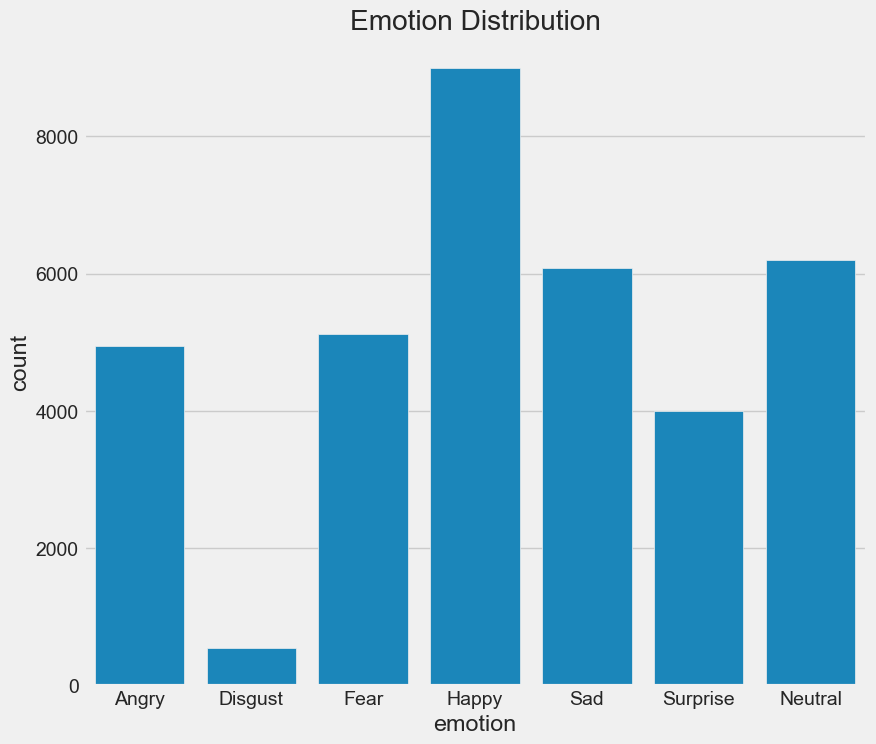

In [12]:
plt.figure(figsize=(9, 8))
sns.countplot(x=dataset.emotion)
_ = plt.title('Emotion Distribution')
_ = plt.xticks(ticks=range(0, 7), labels=[emotions[i] for i in range(0, 7)], )

In [13]:
def image_transformations() -> (object, object):
    '''
        Return transformations to be applied.
        Input:
            None
        Output:
            train_tfms: transformations to be applied on the training set
            valid_tfms: transformations to be applied on the validation or test set
    '''

    train_trans = [      
        T.RandomCrop(48, padding=4, padding_mode='reflect'),     
        T.RandomRotation(15),
        T.RandomAffine(
            degrees=0,
            translate=(0.01, 0.12),
            shear=(0.01, 0.03),
        ),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
    ]

    val_trans = [
        T.ToTensor(), 
    ]

    train_transformations = T.Compose(train_trans)
    valid_tfms = T.Compose(val_trans)

    return train_transformations, valid_tfms

In [14]:
def get_train_dataset(dataframe: object, transformation: bool=True) -> (object, object):
    '''
        Returns an object on FERDataset class
        Input:
            dataframe: object -> DataFrame object containing the whole data
            transformation: bool [optional] ->  Apply transformations
    '''

    # extracts rows specific to Training, PublicTest
    dataframe = dataframe.loc[dataframe.Usage.isin(['Training', 'PublicTest'])]
    # drop Usage column as it's no longer needed    
    dataframe = dataframe.drop('Usage', axis=1)

    # split dataset into training and validation set
    np.random.seed(42)  
    msk = np.random.rand(len(dataframe)) < 0.8

    train_df = dataframe[msk].reset_index()
    val_df = dataframe[~msk].reset_index()

    # get transformations
    if transformation:
        train_tfms, valid_tfms = image_transformations()
    else:
        train_tfms, valid_tfms = None, None

    # fetch dataset
    train_ds = FERDataset(dataframe, transform=train_tfms)
    val_ds = FERDataset(dataframe, transform=valid_tfms)
    return train_ds, val_ds

In [15]:
def get_train_dataloader(dataframe: object, transformation=True, batch_size: int=64) -> (object, object):
    '''
        Returns train and test dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            train_dl: train dataloader object
            valid_dl: validation dataloader object
    '''
    # fetech train and validation dataset
    train_ds, valid_ds = get_train_dataset(dataframe, transformation=transformation)
    
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                     num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)
    
    return train_dl, valid_dl

In [16]:
def get_test_dataloader(dataframe: object, batch_size: int=128) -> object:
    '''
        Returns test set dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            test_dl: test dataloader object
    '''
    # extracts rows specific to PrivateTest
    test_df = dataframe.loc[dataset.Usage.isin(['PrivateTest'])]

    # drop Usage column as it's no longer needed
    test_df = test_df.drop('Usage', axis=1)

    # get transformations same as validation set
    _, valid_tfms = image_transformations()
    
    test_dataset = FERDataset(test_df, transform=valid_tfms)
    test_dl = DataLoader(test_dataset, batch_size, num_workers=3 , pin_memory=True)

    # move loader to GPU (class defined ahead)
    test_dl = DeviceDataLoader(test_dl, device)
    return test_dl

In [17]:
train_dl_un, _ = get_train_dataloader(dataset, transformation=False)
train_dl, _ = get_train_dataloader(dataset)

In [18]:
for images, _ in train_dl_un:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

_ = plt.suptitle("Images", y=0.92, fontsize=16)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'FERDataset' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


KeyboardInterrupt: 

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

_ = plt.suptitle("Transformed Images", y=0.92, fontsize=16)